# CLIP - Learning Transferable Visual Models From Natural Language Supervision

https://arxiv.org/abs/2103.00020

## Imports

In [64]:
import os
import cv2
import albumentations as A
import timm

import pandas as pd

from transformers import DistilBertTokenizer

import matplotlib.pyplot as plt

import torch
from torch import nn

## Parameters

In [59]:
class param():
    
    # Dataset    
    max_length     = 10
    image_path     = 'Images'
    size           = 224
    text_tokenizer = "distilbert-base-uncased"
    
    # Model
    model_name = 'resnet50'
    
    pretrained = False
    trainable  = False
    
param = param()

## Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = "guisilvapa"
os.environ['KAGGLE_KEY']      = "4b495b36de19da12b4f4c7b1426d221b"

In [ ]:
# For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"

# For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_filenames, captions, tokenizer, transforms):

        self.image_filenames  = image_filenames
        self.captions         = list(captions)
        self.encoded_captions = tokenizer(list(captions), padding=True, truncation=True, max_length=param.max_length)
        self.transforms       = transforms

    def __getitem__(self, idx):
        
        item = {key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()}

        image = cv2.imread(f"{param.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        
        item['image']   = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item

    def __len__(self):
        return len(self.captions)

In [4]:
img_text_df = pd.read_csv("captions.txt")
img_text_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [56]:
transforms = A.Compose([A.Resize(param.size, param.size, always_apply=True),
                        A.Normalize(max_pixel_value=255.0, always_apply=True)])

tokenizer  = DistilBertTokenizer.from_pretrained(param.text_tokenizer)

dataset = CustomDataset(img_text_df["image"].values,
                        img_text_df["caption"].values,
                        tokenizer=tokenizer,
                        transforms=transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


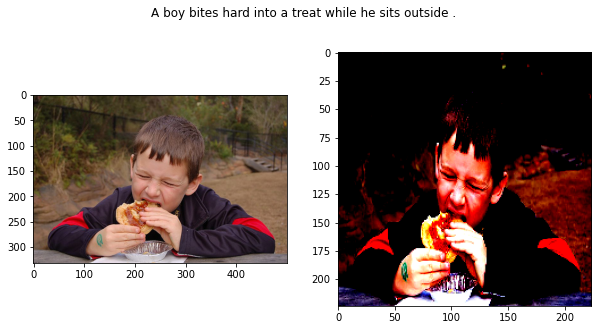

In [57]:
exe = 150

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
fig.suptitle(dataset[exe]['caption'])

img = mpimg.imread("Images/" + img_text_df["image"].values[exe])
axs[0].imshow(img)

axs[1].imshow(dataset[exe]['image'].permute(1, 2, 0))

plt.show()

In [62]:
class ImageEncoder(nn.Module):

    def __init__(self, model_name=param.model_name, pretrained=param.pretrained, trainable=param.trainable):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained, num_classes=0, global_pool="avg")
        
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [79]:
imgEncoder = ImageEncoder(dataset[exe]['image'])
x = imgEncoder(dataset[0]['image'].unsqueeze(dim=0))
x

TypeError: split_with_sizes(): argument 'split_sizes' (position 1) must be tuple of ints, not str

In [78]:
dataset[0]['image'].unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])